In [1]:
#import timeit

import matplotlib.pylab as pylab
import numpy as np
#import numpy.fft as fft
#from   PIL import Image
from   scipy import ndimage, misc, signal
import scipy.fftpack as fp
#from   scipy.stats import signaltonoise # deprecated
#from   skimage import data, img_as_float
from   skimage.color import rgb2gray
from   skimage.io import imread, imshow, show
#from   skimage.transform import rescale

#%matplotlib inline

In [2]:
IMG = '../../../images'

In [3]:
im = rgb2gray(imread(f'{IMG}/cameraman.jpg')).astype(float)
np.max(im)

0.9921568627450981

In [4]:
im.shape

(256, 256)

In [5]:
blur_box_kernel = np.ones((3, 3)) / 9
edge_laplace_kernel = np.array([[0,  1, 0],
                                [1, -4, 1],
                                [0,  1, 0]])
im_blurred = signal.convolve2d(im, blur_box_kernel)
im_edges = np.clip(signal.convolve2d(im, edge_laplace_kernel), 0, 1)

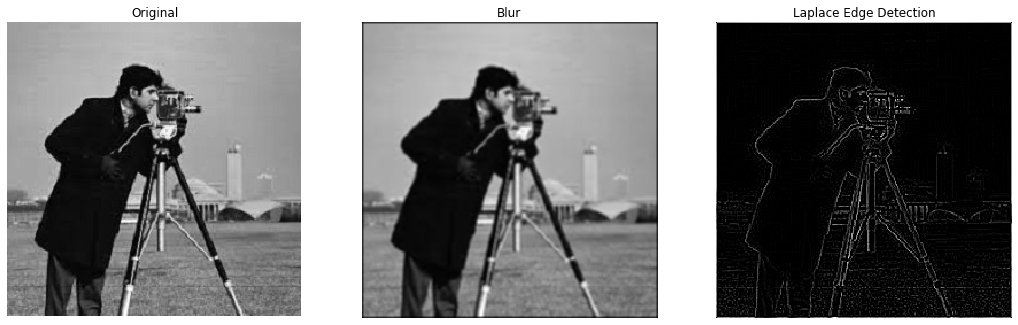

In [6]:
fig, axes = pylab.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(18, 6))
axes[0].imshow(im, cmap=pylab.cm.gray)
axes[0].set_title('Original')
axes[1].imshow(im_blurred, cmap=pylab.cm.gray)
axes[1].set_title('Blur')
axes[2].imshow(im_edges, cmap=pylab.cm.gray)
axes[2].set_title('Laplace Edge Detection')

for ax in axes:
    ax.axis('off')

### Image Sharpening

In [7]:
im = imread(f'{IMG}/tajmahal.jpg') / 255
print(np.max(im), im.shape)

1.0 (1018, 1645, 3)


In [8]:
emboss_kernel = np.array([[-1,  -0.5,   0],
                          [-0.5, 0.5, 0.5],
                          [ 0,   0.5,   1]])
edge_schar_kernel = np.array([[ -3-3j, 0-10j,  3-3j],
                              [-10+0j, 0+ 0j, 10+0j],
                              [ -3+3j, 0+10j,  3+3j]])
im_embossed = np.ones(im.shape)
im_edges = np.ones(im.shape)

for i in range(3):
    im_embossed[..., i] = np.clip(
        signal.convolve2d(
            im[..., i], emboss_kernel, mode='same', boundary='symm'), 
        0, 
        1)
for i in range(3):
    im_edges[:, :, i] = np.clip(
        np.real(
            signal.convolve2d(im[..., i],
                              edge_schar_kernel, 
                              mode='same', 
                              boundary='symm')), 
        0, 
        1)

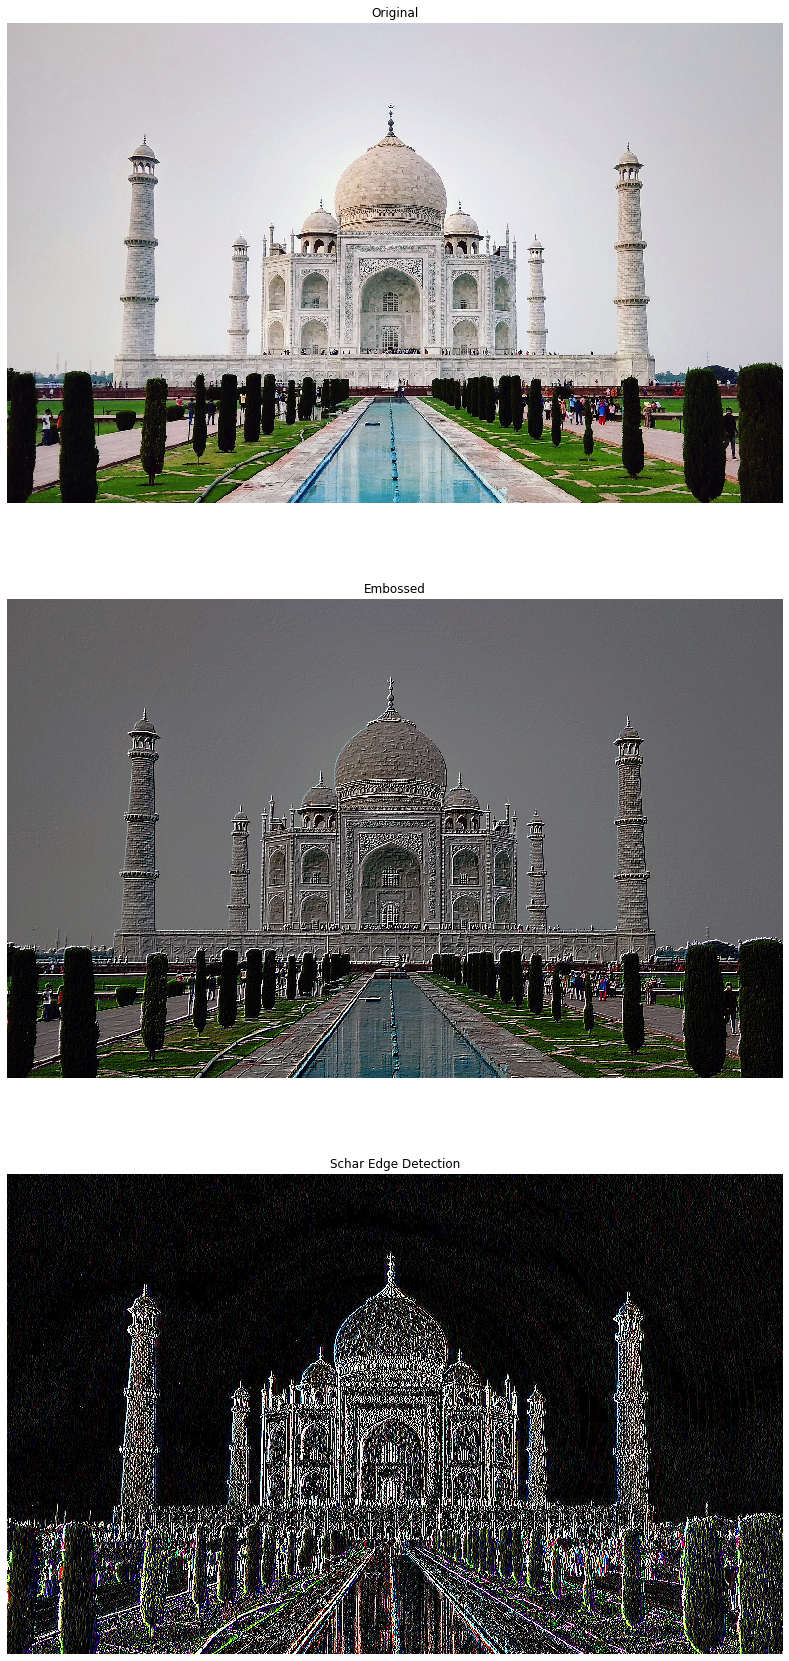

In [9]:
fig, axes = pylab.subplots(nrows=3, figsize=(20, 30))
axes[0].imshow(im)
axes[0].set_title('Original')
axes[1].imshow(im_embossed)
axes[1].set_title('Embossed')
axes[2].imshow(im_edges)
axes[2].set_title('Schar Edge Detection')
for ax in axes:
    ax.axis('off')

### Using Scipy `ndimage.convolve`

In [10]:
im = imread(f'{IMG}/tajmahal.jpg').astype(np.float)
np.max(im)

255.0

In [11]:
sharpen_kernel = np.array([[ 0, -1,  0], 
                           [-1,  5, -1], 
                           [ 0, -1,  0]]).reshape((3, 3, 1))
emboss_kernel = np.array([[-2, -1, 0],
                          [-1,  1, 1], 
                          [ 0,  1, 2]]).reshape(3, 3, 1)

In [12]:
im_sharp = ndimage.convolve(im, sharpen_kernel, mode='nearest')
im_sharp = np.clip(im_sharp, 0, 255).astype(np.uint8)

In [13]:
im_emboss = ndimage.convolve(im, emboss_kernel, mode='nearest')
im_emboss = np.clip(im_emboss, 0, 255).astype(np.uint8)

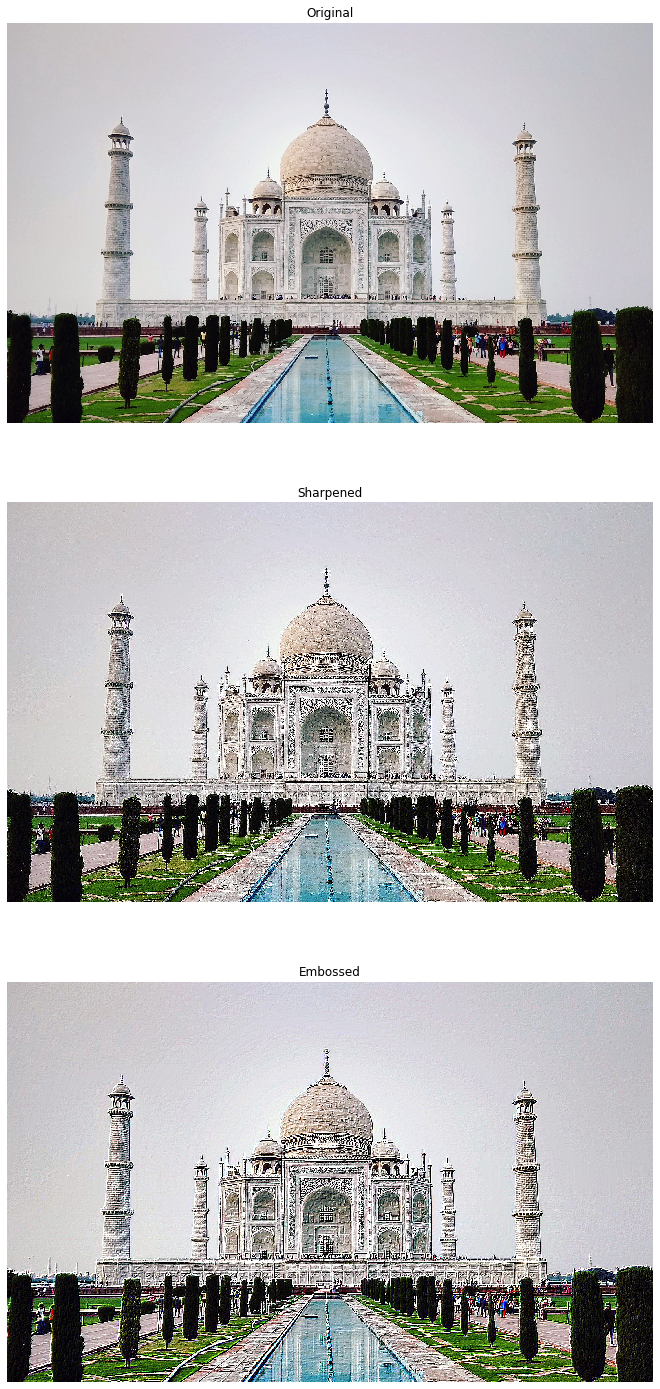

In [14]:
pylab.figure(figsize=(15, 25))

pylab.subplot(311)
pylab.imshow(im.astype(np.uint8))
pylab.axis('off')
pylab.title('Original')

pylab.subplot(312)
pylab.imshow(im_sharp)
pylab.axis('off')
pylab.title('Sharpened')

pylab.subplot(313)
pylab.imshow(im_emboss)
pylab.axis('off')
pylab.title('Embossed');

### Cross-Correlation

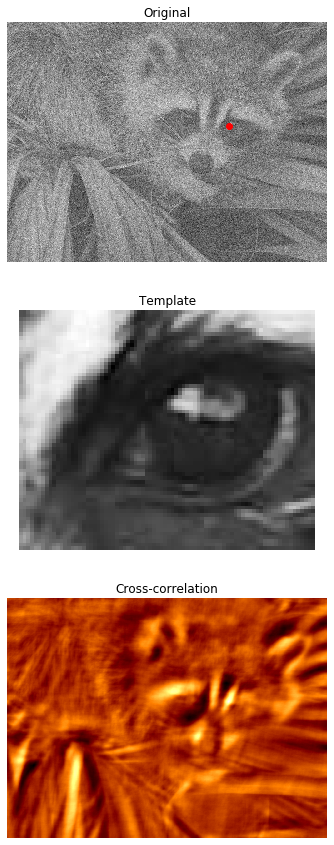

In [15]:
face_image = misc.face(gray=True) - misc.face(gray=True).mean()
template_image = np.copy(face_image[300:365, 670:750]) # right eye
template_image -= template_image.mean()
# add random noise
face_image = face_image + np.random.randn(*face_image.shape) * 50 
correlation = signal.correlate2d(
    face_image, template_image, boundary='symm', mode='same')
# find the match
y, x = np.unravel_index(np.argmax(correlation), correlation.shape) 
fig, (ax_original, ax_template, ax_correlation) = pylab.subplots(
    3, 1, figsize=(6, 15))
ax_original.imshow(face_image, cmap='gray')
ax_original.set_title('Original')
ax_original.set_axis_off()
ax_template.imshow(template_image, cmap='gray')
ax_template.set_title('Template')
ax_template.set_axis_off()
ax_correlation.imshow(correlation, cmap='afmhot')
ax_correlation.set_title('Cross-correlation')
ax_correlation.set_axis_off()
ax_original.plot(x, y, 'ro');

That is, brighter spots more correlated with eye-region template

In [16]:
im = np.mean(imread(f'{IMG}/lena.jpg'), axis=2)
gauss_kernel = np.outer(signal.gaussian(im.shape[0], 5), 
                        signal.gaussian(im.shape[1], 5))
freq = fp.fft2(im)
assert(freq.shape == gauss_kernel.shape)

In [17]:
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel))
convolved = freq * freq_kernel
im1 = fp.ifft2(convolved).real

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


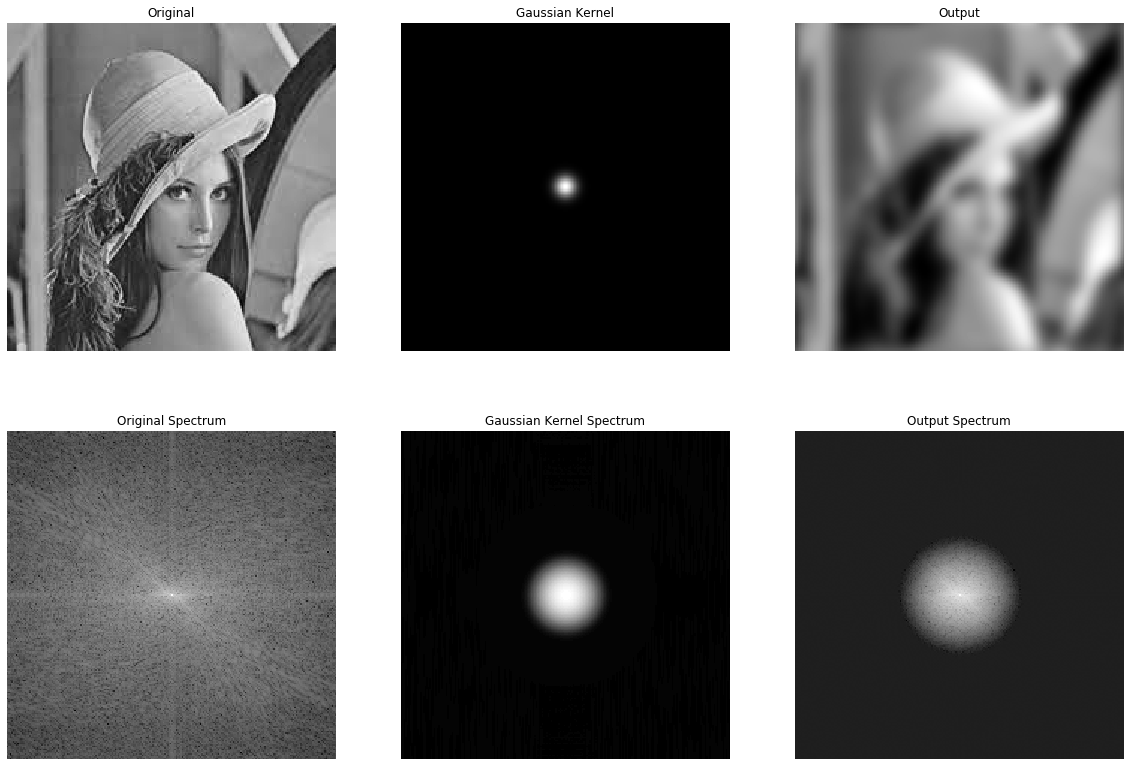

In [18]:
pylab.figure(figsize=(20, 15))
pylab.gray()

pylab.subplot(2, 3, 1)
pylab.imshow(im)
pylab.title('Original')
pylab.axis('off')

pylab.subplot(2, 3, 2)
pylab.imshow(gauss_kernel)
pylab.title('Gaussian Kernel')
pylab.axis('off')

pylab.subplot(2, 3, 3)
pylab.imshow(im1)
pylab.title('Output')
pylab.axis('off')

pylab.subplot(2, 3, 4)
pylab.imshow((20*np.log10(0.1 + fp.fftshift(freq))).astype(int))
pylab.title('Original Spectrum')
pylab.axis('off')

pylab.subplot(2, 3, 5)
pylab.imshow((20*np.log10(0.1 + fp.fftshift(freq_kernel))).astype(int))
pylab.title('Gaussian Kernel Spectrum')
pylab.axis('off')

pylab.subplot(2, 3, 6)
pylab.imshow((20*np.log10(0.1 + fp.fftshift(convolved))).astype(int))
pylab.title('Output Spectrum')
pylab.axis('off')

pylab.subplots_adjust(wspace=0.2, hspace=0)

### Gaussian Kernel in the Frequency Domain

In [19]:
im = rgb2gray(imread(f'{IMG}/lena.jpg'))
gauss_kernel = np.outer(signal.gaussian(im.shape[0], 1), 
                        signal.gaussian(im.shape[1], 1))
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel))

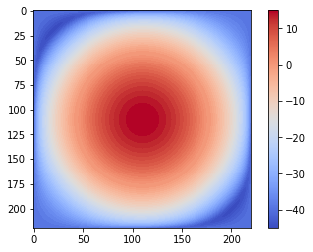

In [20]:
pylab.imshow(
    (20 * np.log10(0.01 + fp.fftshift(freq_kernel))).real.astype(int), 
    cmap='coolwarm')
pylab.colorbar();

### Freq Domain Gaussian Blur Filter w `scipy signal.fftconvole()`

In [22]:
im = np.mean(imread(f'{IMG}/lena.jpg'), axis=2)
im.shape

(220, 220)

In [23]:
gauss_kernel = np.outer(signal.gaussian(11, 3), signal.gaussian(11, 3))
im_blurred = signal.fftconvolve(im, gauss_kernel, mode='same')

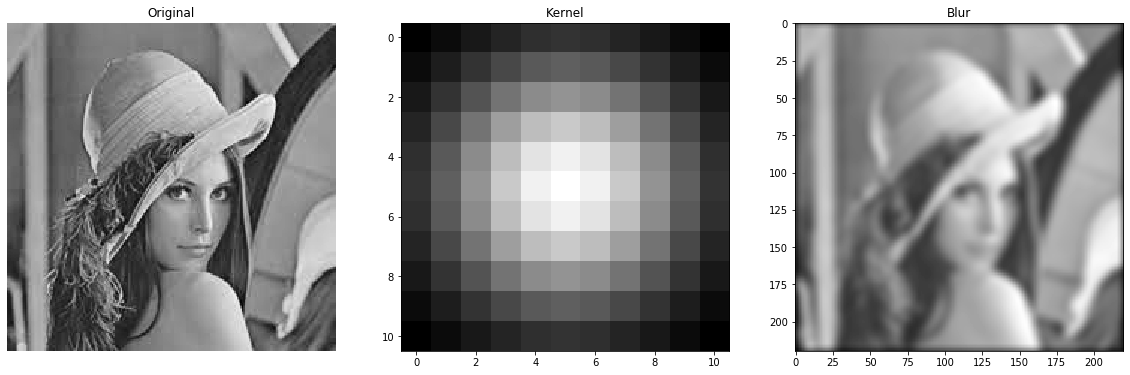

In [24]:
fig, (ax_orig, ax_kernel, ax_blurred) = pylab.subplots(
    1, 3, figsize=(20, 8))
ax_orig.imshow(im, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()

ax_kernel.imshow(gauss_kernel)
ax_kernel.set_title('Kernel')
ax_orig.set_axis_off()

ax_blurred.imshow(im_blurred, cmap='gray')
ax_blurred.set_title('Blur')
ax_orig.set_axis_off()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Blurred Image Spectrum')

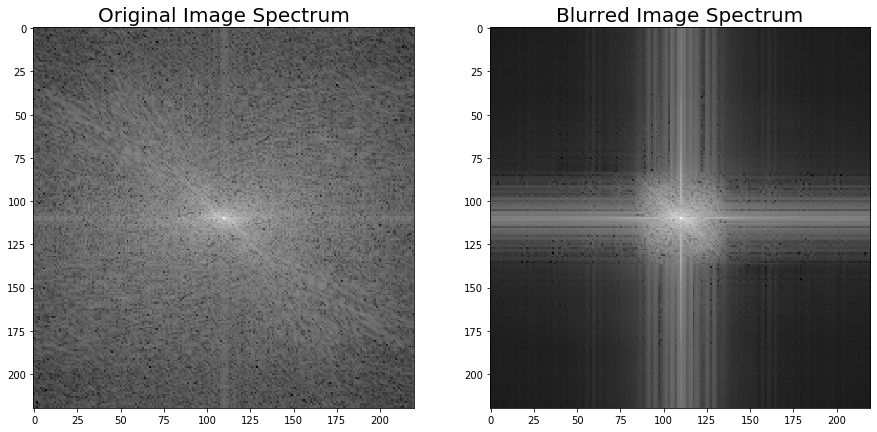

In [26]:
F1 = fp.fft2((im).astype(float))
F2 = fp.fftshift(F1)
pylab.figure(figsize=(15, 8))
pylab.subplot(1, 2, 1)
pylab.imshow((20 * np.log10(0.1 + F2)).astype(int), cmap=pylab.cm.gray)
pylab.title('Original Image Spectrum', size = 20)
F1 = fp.fft2((im_blurred).astype(float))
F2 = fp.fftshift(F1)
pylab.subplot(1, 2, 2)
pylab.imshow((20 * np.log10(0.1 + F2)).astype(int), cmap=pylab.cm.gray)
pylab.title('Blurred Image Spectrum', size=20)